In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure import plotter
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
mp_key = "kUNltwLCR9AdLypQdV0AJRVJ3G9Yb7B8"
mp_id = "mp-8426"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='$\\mathrm{E\\ -\\ E_f\\ (eV)}$'>

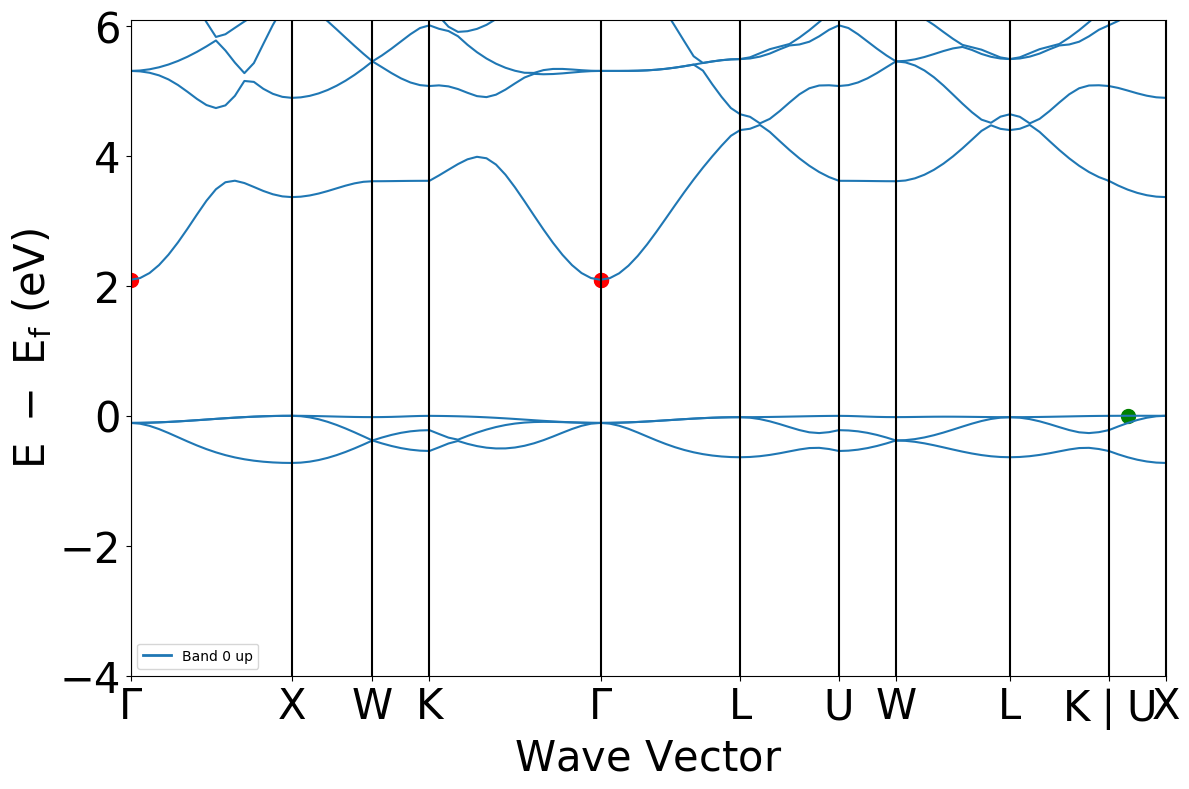

In [4]:
# Visualisation des bandes électroniques

plot = BSPlotter(el_bs)
plot.get_plot(vbm_cbm_marker=True)

## Bande interdite

In [6]:
print("Bande interdite : \n")
gap = el_bs.get_band_gap()
e_band = gap.get('energy')
print('Energie de la bande :', e_band, 'eV.')
if gap.get('direct') == False:
    print('La bande interdite est indirecte.')
else:
    print('La bande interdite est directe.')

print("Vecteur de transition :", gap['transition'])

Bande interdite : 

Energie de la bande : 2.0925000000000002 eV.
La bande interdite est indirecte.
Vecteur de transition : (0.583,0.167,0.583)-\Gamma


Commentaire :

La bande interdite est a une largeur de 2.0925 eV.  Il s'agit de l'énergie que l'électron doit acquérir pour passer de la bande de valence à la bande de conduction. La bande interdite est indirecte car le vecteur de transition passe du point (0.583,0.167,0.583) au point Gamma.
La bande interdite correspond à toute une bande de valeurs énergétiques dont les niveaux ne peuvent être occupés par les électrons du cristal.

## Dernière bande de valence et première bande de conduction

In [7]:
# Recherche de la dernière bande de valence

print("Dernière bande de valence : \n")
data = plotter.BSPlotter(el_bs).bs_plot_data()
x = data.get('ticks').get('distance')
x = np.array([x[0], x[1], x[3], x[5], x[7], x[9], x[11], x[13], x[15], x[17], x[18]])
y = data.get('energy')


vbm = el_bs.get_vbm()
E_vbm = vbm['energy']

print('Energie du maximum de la bande de valence = {} eV'.format(E_vbm))
print(vbm.get('band_index'))

Dernière bande de valence : 

Energie du maximum de la bande de valence = -0.7274 eV
defaultdict(<class 'list'>, {<Spin.up: 1>: [11]})


La bande 11 contient l'énergie maximum de la bande de valence (-0.7274 eV). Il s'agit de la dernière bande de valence.

In [8]:
# Recherche de la première bande de conduction 

print("Première bande de conduction : \n")
cbm = el_bs.get_cbm()
E_cbm = cbm['energy']

print('Energie du minimum de la bande de conduction = ',E_cbm,'eV')
print(cbm.get('band_index'))

Première bande de conduction : 

Energie du minimum de la bande de conduction =  1.3651 eV
defaultdict(<class 'list'>, {<Spin.up: 1>: [12]})


La bande 12 contient l'énergie minimum de la bande de conduction (1.3651 eV). En calculant la différence avec la dernière bande de valence (1.3651 + 0.7274 = 2.0925), on obtient bien la largeur de la bande interdite. Il s'agit donc bien de la première bande de conduction.

Pour ce cristal, l'intervalle des valeurs énergétiques dont les niveaux ne peuvent être occupés est [-0,7274 ; 1.3651] [eV]

## Dispersion

In [9]:
data = plotter.BSPlotter(el_bs).bs_plot_data()
x = data.get('ticks').get('distance')
x = np.array([x[0], x[1], x[3], x[5], x[7], x[9], x[11], x[13], x[15], x[17], x[18]])
y = data.get('energy')
dx = np.zeros(10)
dyc = np.zeros(10)
dyv = np.zeros(10)
mc = np.zeros(10)
mv = np.zeros(10)

for i in range(10):
    dx[i] = x[i+1] - x[i]
    
for i in range(10):
    dyv[i] =y.get('1')[i][14][-1] - y.get('1')[i][14][0]
    dyc[i] =y.get('1')[i][15][-1] - y.get('1')[i][15][0]
    
for i in range (10):
    mc[i] = dyc[i]/dx[i]
    mv[i] = dyv[i]/dx[i] 
    

print("En valeur absolue:")
mxV = np.max(abs(mv))
print("Dispersion maximale pour la bande de valence: ", mxV)
mxC = np.max(abs(mc))
print("Dispersion maximale pour la bande de conduction: ", mxC)
mnV = np.min(abs(mv))
print("Plus faible dispersion pour la bande de valence: ", mnV)
mnC = np.min(abs(mc))
print("Plus faible dispersion pour la bande de conduction: ", mnC)

En valeur absolue:
Dispersion maximale pour la bande de valence:  2.2388367486672847
Dispersion maximale pour la bande de conduction:  2.481687320563763
Plus faible dispersion pour la bande de valence:  0.06163373953613736
Plus faible dispersion pour la bande de conduction:  0.22034498383740372


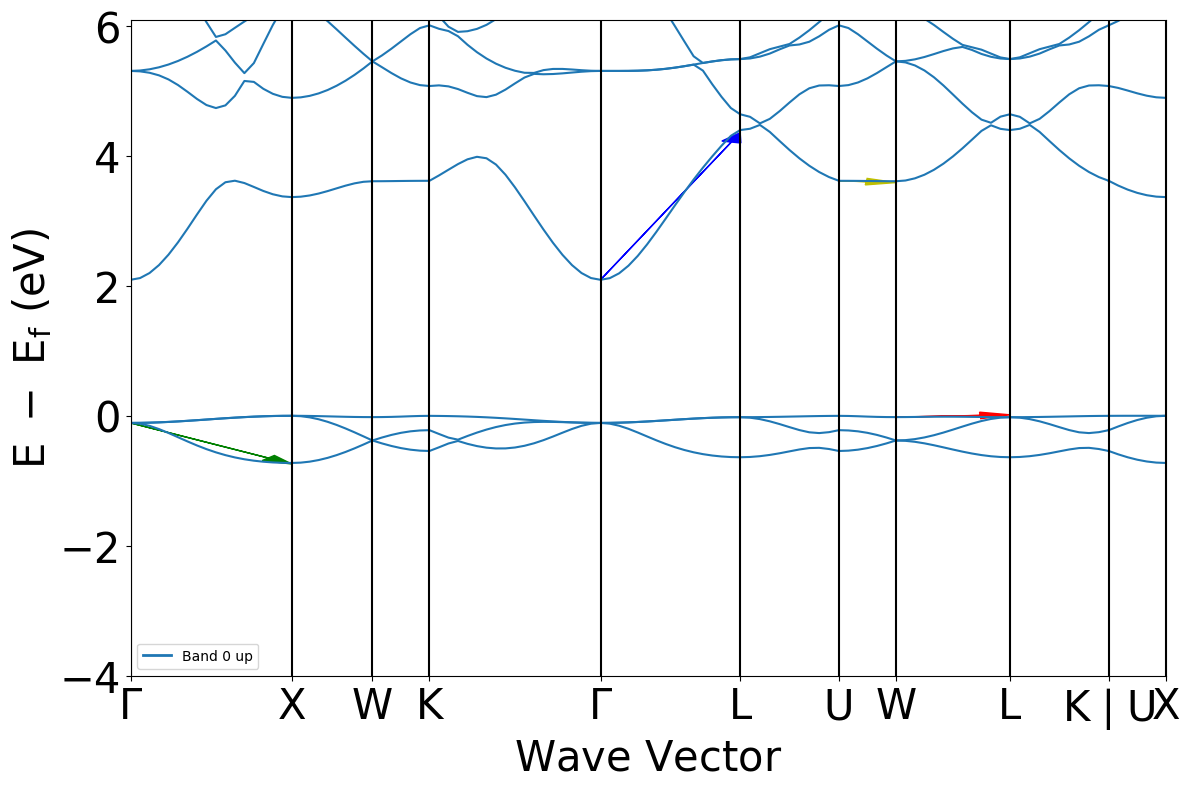

In [10]:
BSPlotter(el_bs).get_plot()

i = 0  
j = 7  
k = 4  
l = 6  


#bande de valence, dispersion maximale
plt.arrow(x[i], (y.get('1')[i][11])[0], dx[i], -0.6*dyv[i], color = 'g', head_width = 0.1,length_includes_head=True)

#bande de valence, plus faible dispersion
plt.arrow(x[j], (y.get('1')[j][11])[0], dx[j], dyv[j], color = 'r', head_width = 0.1,length_includes_head=True)

#bande de conduction, dispersion maximale
plt.arrow(x[k], (y.get('1')[k][12])[0], dx[k], -1.3*dyc[k], color = 'b', head_width = 0.1,length_includes_head=True)

#bande de conduction, plus faible dispersion
plt.arrow(x[l], (y.get('1')[l][12])[0], dx[l], 0.3*dyc[l], color = 'y', head_width = 0.1,length_includes_head=True)


plt.show()

Commentaires : 

Pour la bande de valence, la flèche verte représente la dispersion maximale et la flèche rouge représente la plus faible dispersion.

Pour la bande de conduction, la flèche bleue représente la dispersion maximale et la flèche jaune représente plus faible dispersion.

## Calcul des masses effectives

Pour calculer la masse effective (en supposant une dispersion parabolique), on peut utiliser la formule suivante :



$$ m^* = \frac{\hbar^2 \cdot k^2}{2 \cdot E(k)} = \frac{\hbar^2 \cdot (k_x^2 + k_y^2 + k_z^2)}{2 \cdot E(k)} $$


E(k) est l'énergie d'un électron de vecteur d'onde k dans la bande considérée et ${\hbar} = \frac{h}{2\pi}$ avec 
h la constante de Planck et vaut 6.626 x $10^{-34}$ Js.

In [11]:
h = (6.62607015*10**(-34))/(2*np.pi) 
eV = 1.602176634*10**(-19) 
h_bar = 6.5821e-16 #h/eV 
kpoint_vbm = vbm['kpoint'].cart_coords
m_vbm = (h_bar**2 * (kpoint_vbm[0]**2+kpoint_vbm[1]**2+kpoint_vbm[2]**2))/(2*abs(vbm['energy']))
print('La masse effective au sommet de la dernière bande de valence = {} kg.'.format(m_vbm))

La masse effective au sommet de la dernière bande de valence = 2.0622870631294117e-31 kg.


In [12]:
kpoint_cbm = cbm['kpoint'].cart_coords

m_cbm = (h_bar**2 * (kpoint_cbm[0]**2+kpoint_cbm[1]**2+kpoint_cbm[2]**2))/(2*cbm['energy'])
print('La masse effective à la base de la première bande de conduction = {} kg.'.format(m_cbm))

La masse effective à la base de la première bande de conduction = 0.0 kg.
